In [1]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

# The Impacts of Different Music Genres and Temperature on Running

_By: Riley Sikes_  
_Class: CPSC 22, Fall 2020_

## Introduction

### Domain

* My project is about my running and the impact the different music I listen to and the temperature has on my pace, time, etc. Each run is roughly a 5k and I run the same course everytime so it's easy to track change. I started running this route on October 5th and ran 3 times a week, totaling 30 runs, 10 for each of the genres I listened to up until December 10th. I have three different playlists that I shuffle through (that I made): Pop, Rap, and Folk. 
* I get my weather data from [this](https://www.wunderground.com/history/daily/us/wa/spokane/KGEG/date/2020-11-19) website that allows me to get the weather at the time I ran. 
* So the domain would be a combination between the fitness, music, and weather domains.
* Communities would be the biggest stakeholders in my data because it has to with the impacts of music on health. It could also be customers that run and are looking to purchase music. Both Strava and Spotify would be stakeholders because I'm using data from their websites.

### Hypotheses

* My hypotheses are that on average my fastest runs, when grouped by playlist, will be in order of Rap, Pop, and Folk. I also think that my faster runs will be towards the end of the semester because I'll probably be getting slightly faster over time. I also think that we will see a correlation between moderate temperatures and faster times. 

### Classification Method

* The task I chose to use machine learning was predicting the music genre when given running statistics and temperature. I made a kNN neighbors classifier and a decision tree classifier to predict the genre of music I would be listening to given the "Average Speed", "Max Speed", and "Temperature" features. Both classifiers end up having the same accuracy of 0.625.


## Data Analysis

#### Strava (and Temperature) Data
* The strava data is automatically collected each time I run. It uses a .csv format to store the data. It keeps track of a bunch of statistics like distance, moving time, elevation gain and loss, average speed, etc, but we're mainly going to be looking at average speed.
* The features of the dataset are "Activity Description", "Activity ID", "Elevation High", "Activity Date", "Activity Name", "Activity Type", "Average Grade", "Max Grade", "Elevation Loss", "Grade Adjusted Distance", "Elevation Gain", "Distance", "Moving Time", "Elapsed Time", "Elevation Low", "Average Speed", "Temperature", and "Max Speed".
    * We're mainly only going to be looking at "Average Speed", "Max Speed", and "Temperature".
* To clean/prepare the data I had to delete columns that had characters that pandas couldn't process and convert some values to different units (like m/s to mph for average speed). I also went in afterwards and manually added the temperature at the time I ran from the website linked above.


#### Spotify Data
* The spotify data is automatically collected anytime I play a song on spotify. It keeps track of each song I listen to in a JSON format. The individual songs I listen to aren't as important as the general genre of the music I'm listneing to, so this data isn't super necessary. It does allow for other analysis to be done in the future, like using the spotify API to get the genre of each song to see how accurate my song groupings are.
* Each song datapoint in the dataset has the "title", "artist", and "end time".


### Exploratory Data Analysis

In [2]:
spotify_df = pd.read_json("StreamingHistory2.json")
spotify_df.to_csv("SpotifyHistory.csv")

playlist_df = pd.read_json("Playlist1.json")
playlist_df.to_csv("Playlists.csv")

og_strava_df = pd.read_csv("StravaFinalRuns.csv")
strava_df = og_strava_df.copy()

In [3]:
# converting the average speed and max speed from meter/second to miles/hour
utils.convert_to_MPH(strava_df)

#### Plotting Data
* Below I plot the average speed, start temperature, and max speed for all my runs below. Just by looking at the data it seems like there might be a slight increase over time for the speed graphs. The temperature graph depicts a general decreasing trend which is expected because my dataset is collected from October 5th to December 10th.

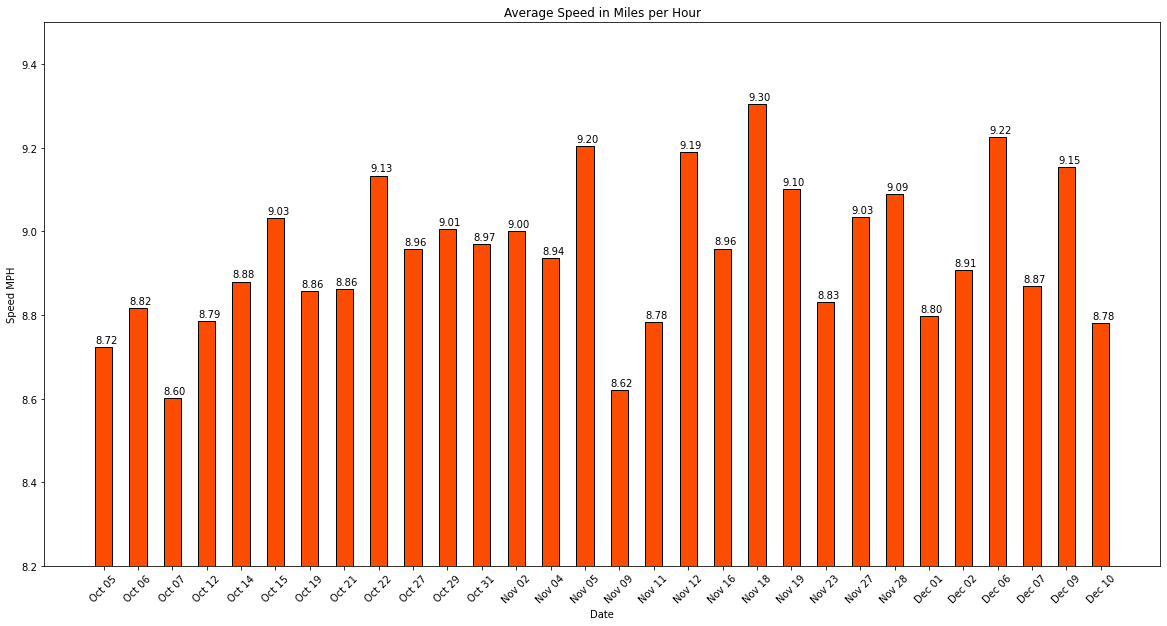

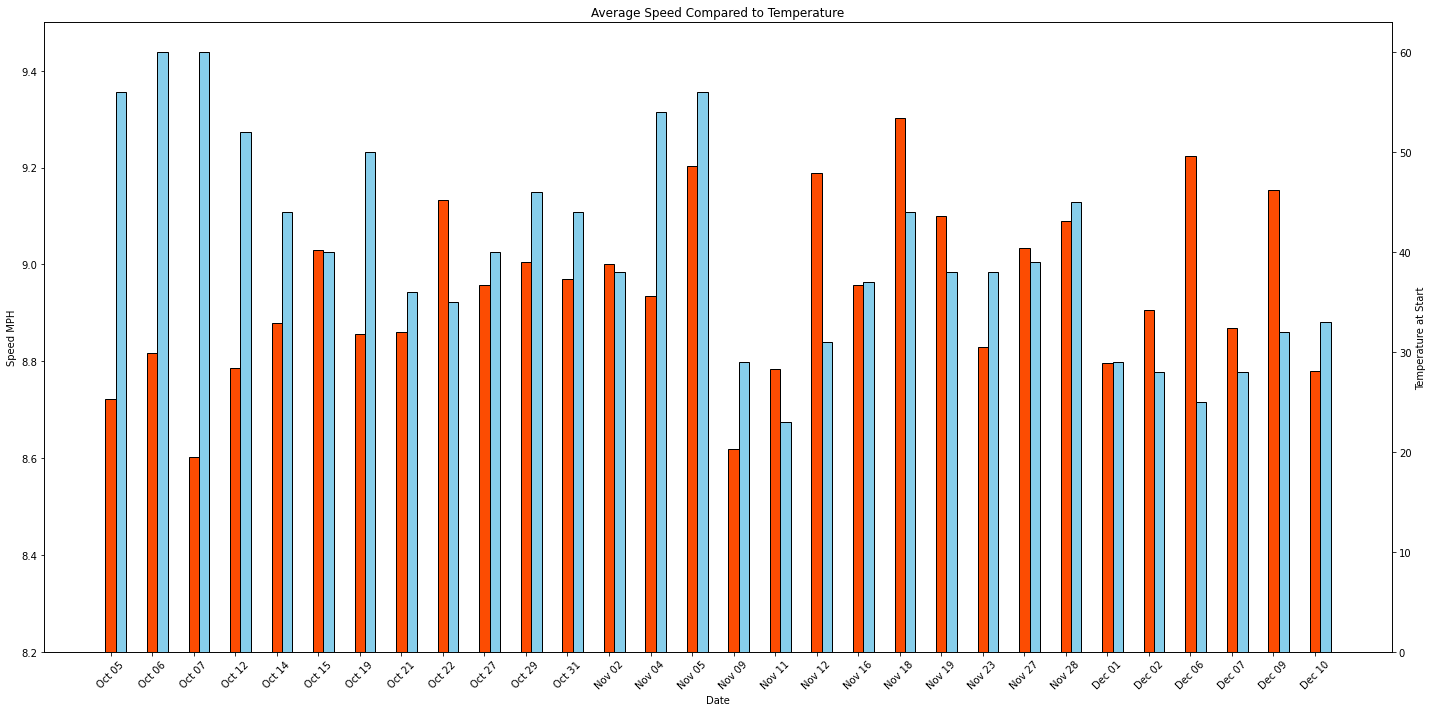

In [4]:
average_speed_ser = strava_df["Average Speed"]
temperature_ser = strava_df["Temperature at Start"]
dates_ser = strava_df["Activity Date"].copy()
for i in range(0, len(dates_ser)):
    dates_ser.loc[i] = ((dates_ser.loc[i]).split(",", maxsplit = 1)[0])

utils.bar_chart(dates_ser, average_speed_ser, "Average Speed in Miles per Hour", "big", "Average Speed")
utils.double_bar_chart(dates_ser, average_speed_ser, temperature_ser, "Average Speed Compared to Temperature", "big", "Average Speed", "Temperature")
#utils.bar_chart(dates_ser, strava_df["Max Speed"], "Max Speed", "big", "Max Speed")

* I made a box plot here because I think they're an interesting visual for looking at averages and outliers. By looking at this we can see that there aren't any significant outliers and the average is spread pretty evenly above and below the mean value.

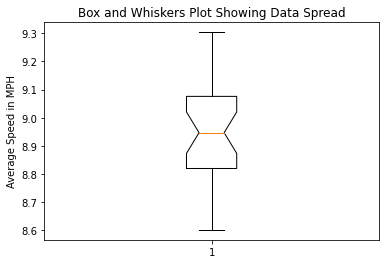

In [5]:
utils.plot_box_plot(strava_df)

* I group my runs by genre listend to here, plot them in separate smaller bar graphs, and print the average speed for each of them. By looking at this we can see that the average speed when I listen to my Folk playlist was the slowest, Pop was in the middle, and Rap was the fastest.

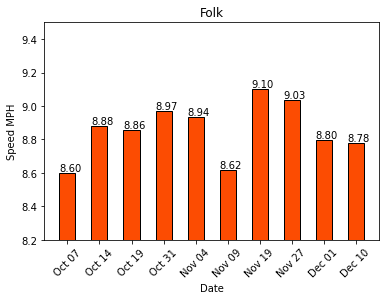

Average Speed When Listening to  Folk  Genre:  8.857546830598903


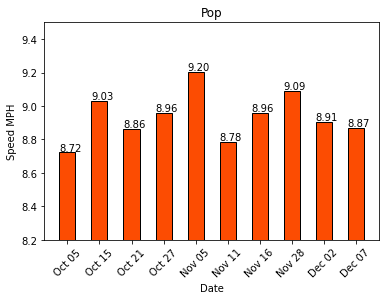

Average Speed When Listening to  Pop  Genre:  8.938431559116658


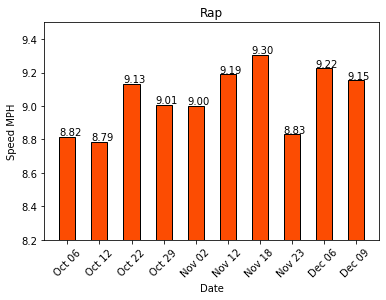

Average Speed When Listening to  Rap  Genre:  9.044166085894087


In [6]:
grouped_by_genre = strava_df.groupby("Activity Description")
folk_df = pd.DataFrame()
rap_df = pd.DataFrame()
pop_df = pd.DataFrame()

for group_name, group_df in grouped_by_genre:
    if group_name == "Pop":
        pop_df = group_df
    elif group_name == "Rap":
        rap_df = group_df
    elif group_name == "Folk":
        folk_df = group_df

    dates_ser = group_df["Activity Date"].copy()
    for i in range(len(dates_ser)):
        dates_ser.iloc[i] = ((dates_ser.iloc[i]).split(",")[0])
        
    utils.bar_chart(dates_ser, group_df["Average Speed"], group_name, "small", "Average Speed")
    average_genre_speed = group_df["Average Speed"].mean()
    print("Average Speed When Listening to ", group_name, " Genre: ", average_genre_speed)

#### Hypothesis Testing
Testing to see if the average speed for my Rap runs is greater than the average speed for my Folk runs with a level of significance of 0.025.

##### Null Hypothesis

$H_0: \mu_{folk} >= \mu_{rap}$  
$H_1: \mu_{folk} < \mu_{rap}$

##### Level of Significance

$\alpha = 0.025$

##### Test Statisitc  
One tailed, independent data sets 
* $ t = \frac{\bar {x_1} - \bar {x_2}}{\sqrt{S_p^2(\frac{1}{n_1} + \frac{1}{n_2})}} $

##### Decision Rule
n = 10 for folk  
n = 10 for rap  
df = 10 + 10 - 2 = 18  
t-critical for a two tailed test with df of 18 and level of significance of 0.025 is 2.093 

If t-computed > 2.093 then reject $H_0$  
If t-computed <= 2.093 then don't reject $H_0$

##### Make Decision


In [7]:
t_computed, p_value = stats.ttest_ind(rap_df["Average Speed"], folk_df["Average Speed"])
print(t_computed, p_value/2)

2.3887085885664914 0.014034716712210715


* t-computed is 2.3887 which is greater than 2.093 so reject $H_0$ and p-value
    is less than $\alpha$ so reject.
* Therefore we can say that my average speed for running while listening to rap music is greater than my average speed while listening to folk music with a level of significance 0.025.
    * I played around with the number a little and found that if the level of significance is 0.01 (98% confidence) insted of 0.025, we fail to reject $H_0$.

***
Testing to see if the average speed for my Rap runs is greater than the average speed for my Pop runs with a level of significance of 0.025.

##### Null Hypothesis

$H_0: \mu_{pop} >= \mu_{rap}$  
$H_1: \mu_{pop} < \mu_{rap}$

##### Level of Significance

$\alpha = 0.025$

##### Test Statisitc  
One tailed, independent data sets 
* $ t = \frac{\bar {x_1} - \bar {x_2}}{\sqrt{S_p^2(\frac{1}{n_1} + \frac{1}{n_2})}} $

##### Decision Rule
n = 10 for pop  
n = 10 for rap  
df = 10 + 10 - 2 = 18  
t-critical for a two tailed test with df of 18 and level of significance of 0.025 is 2.093 

If t-computed > 2.093 then reject $H_0$  
If t-computed <= 2.093 then don't reject $H_0$

##### Make Decision


In [8]:
t_computed, p_value = stats.ttest_ind(rap_df["Average Speed"], pop_df["Average Speed"])
print(t_computed, p_value/2)

1.428942406000926 0.08507286332111313


* t-computed is 1.4289 which is less than 2.093 so do not reject $H_0$ and p-value
    is greater than $\alpha$ so do not reject.
* Therefore we can say that my average speed for running while listening to rap music is not greater than my average speed while listening to pop music with a level of significance of 0.025.
    * If we were to use 0.1 as our level of significance, we would reject $H_0$ because t-critical would be 1.330 which is less than 1.4289 and greater than the p-value.

***
#### Change in Average Speed Over Time

* I also wanted to see if the average speed increased from my early runs to my later runs. To do this I'm going to get the average from my first 15 runs and compare it to my recent 15 runs, just to quicky see if there's a difference.

In [9]:
first_runs_df = strava_df.iloc[:15,:]
recent_runs_df = strava_df.iloc[15:,:]

print("Average speed for first 15 runs:", first_runs_df["Average Speed"].mean())
print("Average speed for recent 15 runs:", recent_runs_df["Average Speed"].mean())

Average speed for first 15 runs: 8.917502770324107
Average speed for recent 15 runs: 8.975926880082328


* Looking at this there is a slight increase of my average speed by about 0.06 mph, but this might not be significant.


#### Hypothesis Testing

Testing to see if the average speed for my recent runs is greater than my first runs with a level of significance of 0.25
##### Null Hypothesis

$H_0: \mu_{first} >= \mu_{recent}$  
$H_1: \mu_{first} < \mu_{recent}$

##### Level of Significance

$\alpha = 0.025$

##### Test Statisitc  
One tailed, independent data sets 
* $ t = \frac{\bar {x_1} - \bar {x_2}}{\sqrt{S_p^2(\frac{1}{n_1} + \frac{1}{n_2})}} $

##### Decision Rule
n = 15 for first
n = 15 for recent
df = 15 + 15 - 2 = 28  
t-critical for a two tailed test with df of 28 and level of significance of 0.025 is 2.048 

If t-computed > 2.048 then reject $H_0$  
If t-computed <= 2.048 then don't reject $H_0$

##### Make Decision


In [10]:
t_computed, p_value = stats.ttest_ind(recent_runs_df["Average Speed"], first_runs_df["Average Speed"])
print(t_computed, p_value/2)

0.9006441012207426 0.18772960188692384


* t-computed is 0.9 which is less than 2.048 so do not reject $H_0$ and p-value
    is greater than $\alpha$ so do not reject.
* Therefore we can say that my average speed for running in the beginning is not greater than my average speed while running recently with a level of significance of 0.025.
***

#### Impact from Temperature

* While running I noticed that when it was warmer out I felt pretty slow (probably because I'm not accustomed to the heat) and when it was really cold, I had to slow down for the ice. So I split the strava data into two groups: a group with temperatures 35-50, and those < 35 and > 50. I chose these temperatures because it evely splits the data.

In [11]:
good_temps = []
extreme_temps = []

for i in range(len(strava_df["Temperature at Start"])):
    if strava_df.iloc[i, 2] >= 35 and strava_df.iloc[i, 2] <= 50:
        good_temps.append(strava_df.iloc[i,10])
    else:
        extreme_temps.append(strava_df.iloc[i, 10])

good_temps_ser = pd.Series(good_temps)
extreme_temps_ser = pd.Series(extreme_temps)
        
print("Average speed in the moderate temperatur range [35 - 50]:", good_temps_ser.mean())
print("Average speed in the extreme temperature range [< 35 and > 50]", extreme_temps_ser.mean())

Average speed in the moderate temperatur range [35 - 50]: 9.00093422945618
Average speed in the extreme temperature range [< 35 and > 50] 8.892495420950256


* Looking at this, we see there is a slight difference in my average speeds by about 0.01, but this might not be significant. 


#### Hypothesis Testing
Testing to see if my average speed was faster when the temperature was 35-50 compared to the other temperatures with a level of significance of 0.25.

##### Null Hypothesis

$H_0: \mu_{extremes} >= \mu_{moderate}$  
$H_1: \mu_{extremes} < \mu_{moderate}$

##### Level of Significance

$\alpha = 0.025$

##### Test Statisitc  
One tailed, independent data sets 
* $ t = \frac{\bar {x_1} - \bar {x_2}}{\sqrt{S_p^2(\frac{1}{n_1} + \frac{1}{n_2})}} $

##### Decision Rule
n = 15 for moderate
n = 15 for extremes
df = 15 + 15 - 2 = 28  
t-critical for a two tailed test with df of 28 and level of significance of 0.025 is 2.048 

If t-computed > 2.048 then reject $H_0$  
If t-computed <= 2.048 then don't reject $H_0$

##### Make Decision


In [12]:
t_computed, p_value = stats.ttest_ind(good_temps_ser, extreme_temps_ser)
print(t_computed, p_value/2)

1.7341969641723387 0.046940937378691976


* t-computed is 1.7342 which is less than 2.048 so do not reject $H_0$ and p-value
    is greater than $\alpha$ so do not reject.
* Therefore we can say that my average speed for running in moderate temperatures is not greater than my average speed while running in extreme temperatures with a level of significance of 0.025.
    * If we were to use 0.05 as our level of significance, we would reject $H_0$ because t-critical would be 1.701 which is less than 1.7342 and greater than the p-value.
***

#### Spotify Data


* By putting the date (formatted like 'Oct 06') of the run into the first paramater in the function below, it will print out all the songs I listend to while running.

In [19]:
# Example dates: Oct 12, Oct 14, Oct 15, Nov 23, Nov 27, Dec 02
utils.print_songs("Dec 02", strava_df, spotify_df, og_strava_df)

Song: Killer Queen
Artist: Queen

Song: Toxic
Artist: Britney Spears

Song: Loser
Artist: Beck

Song: Remember the Name (feat. Styles of Beyond)
Artist: Fort Minor

Song: Qué Maldición
Artist: Banda MS de Sergio Lizárraga

Song: Electric Love
Artist: BØRNS



## Classification Results

* Since my dataset has only 30 datapoints, my classifier isn't the best because it doesn't have enough data to do significant training off of.
* I made a decision tree classifier and kNN classifier for my dataset using 25% of the dataset for test.
    * Both datasets use the same train_test_split which only uses the "Average Speed", "Temperature", and "Max Speed" features because those are the only valuable ones. The other features are either unrelated to my actual running statistics or are related to the route which is constant (the strava data changes because the apps data collection method isn't perfect).
    * The kNN classifier uses 7 for the number of neighbors because I found that to be right amount for the best accuracy and the decsion tree isn't limited by a height restraint for it's best accuracy.
* You can play around with the accuracies of the two by changing which columns are dropped for X, the test size, the max_depth parameter in the DecisionTreeClassifier() function, and by changing the n_neighbors in the KNeighborsClassifier() function.

In [14]:
y = strava_df["Activity Description"]
X = strava_df.drop(["Activity Description", "Activity ID", "Elevation High", "Activity Date", "Activity Name", "Activity Type", "Average Grade", "Max Grade", "Elevation Loss", "Grade Adjusted Distance", "Elevation Gain", "Distance", "Moving Time", "Elapsed Time", "Elevation Low"], axis = 1)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y, test_size=0.25)

* Decision Tree Classifier

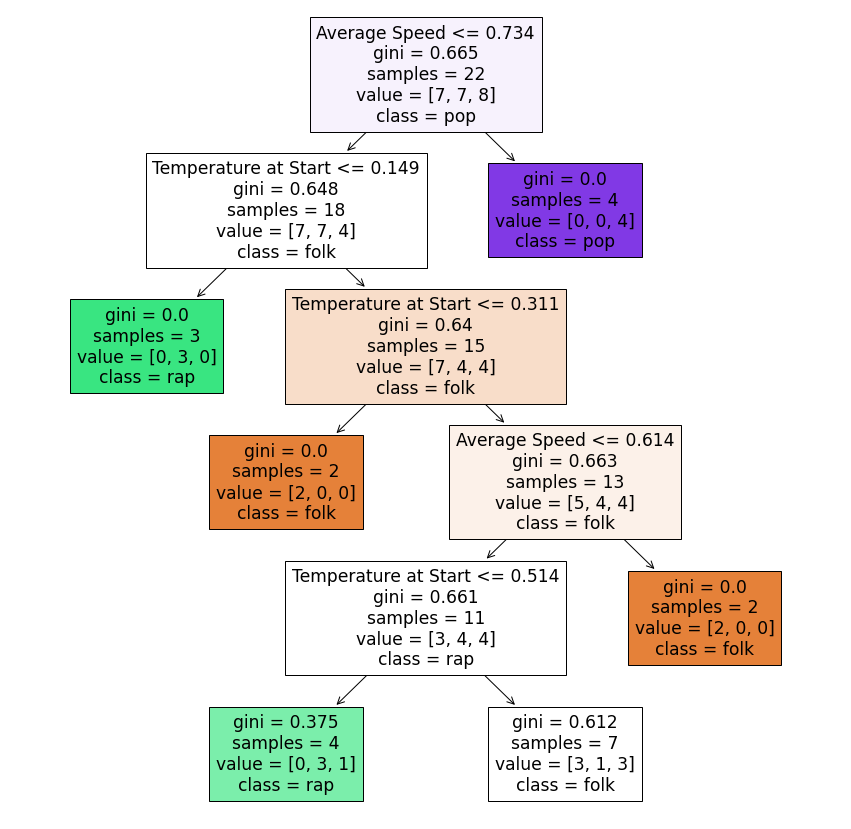

In [15]:
clf = DecisionTreeClassifier(random_state=0, max_depth=5)
clf.fit(X_train, y_train)

utils.plot_decision_tree(clf, X)

* kNN Neighbors Classifier

In [16]:
# Changed the n_neighbors to 7 because that was the best accuracy I could get it too
clfK = KNeighborsClassifier(n_neighbors=7, metric="euclidean")
clfK.fit(X_train, y_train)

accuracy_tree = clf.score(X_test, y_test)
print("Decision tree classifier accuracy:", accuracy_tree)

accuracy = clfK.score(X_test, y_test)
print("kNN neighbors classifier accuracy:", accuracy)

Decision tree classifier accuracy: 0.625
kNN neighbors classifier accuracy: 0.625


* Looking at the two accuracies here, both classifiers have the same accuracy of 0.625. I think this is due to my dataset being small (which results in some inaccuracies) and therefore having a really small test size (only 8). I played around with the n_neighbors and decision tree height to get the accuracies to the best they could be.

## Conclusion

* Based on the exploratory data analysis including the hypothesis testing, it is safe to say that music and temperature does impact running and probably just working out in general. My hypothesis test for seeing if my Rap average speed was greater than my Folk average speed was able to reject the null hypothesis with 95% confidence which is the most significant piece of information I've taken out of this project. The other hypothesis tests were either not able to reject the null hypothesis or needed a much lower confidence level, which I didn't want to change.


#### Challenges
* Strava only allows for one data request per week, which was a small issue when I requested the data before my final run uploaded, so I had to mannually put all the data for that run in.
* Setting up the print_songs() function took a lot of time because the strava and spotify keep track of their dates in very different formats. The majority of that function is making the two match so they're comparable.
* The main classification challenge was getting the classifiers to be accurate when I only have 30 data points. The best accuracy I could get was 0.625 for both my decision tree classifier and kNN neighbors classifier. If I could get more data points to train and test on, I think it would greatly increase the accuracy of both of my classifiers.

#### Ethics
* I don't think any ethical concerns arise from my data. The only implications I could possibly see it having are influencing the music that runners listen to when they're trying to run faster, but you generally don't listen to music during a race. Casual runners probably don't care how fast they're going so they won't be influenced by this data. Spotify and Strava could possibly do a marketing campaign about what type of music to listen to to run faster, but I don't really see this happenning. Also, this is my running data and I'm fine with it being open to the public.